In [58]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

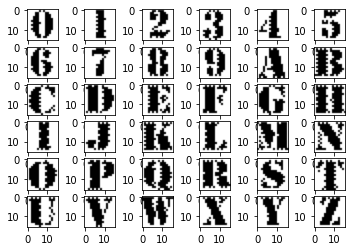

In [59]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([36, 256])
f=lambda x: x + 55 if x > 9 else x + 48
for i in range(0, 36):
    inputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.jpg'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(6,6,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [60]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.Sigmoid()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.Sigmoid()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.Sigmoid()
        self.linear3 = nn.Linear(d_hidden[2], num_classes)
        self.activate3 = nn.Sigmoid()

    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        return res

In [61]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [73]:
# Parameters of training
learning_rate = 0.001
num_epochs = 600
batch_size, input_size, num_classes = 36, 256, 256
d_hidden=[300, 350, 300]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

if not os.path.exists('./models2'):
    os.mkdir('./models2')
torch.save(model, './models2/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models2/' + str(i) + '/'):
        os.mkdir('./models2/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [63]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2533 MAE: 0.4984 Mean Error: 0.1431 STD: 0.4825
[10/600] Loss: 0.1667 MAE: 0.3395 Mean Error: 0.0306 STD: 0.4072
[20/600] Loss: 0.1631 MAE: 0.3208 Mean Error: -0.0014 STD: 0.4039
[30/600] Loss: 0.1621 MAE: 0.3229 Mean Error: -0.0012 STD: 0.4026
[40/600] Loss: 0.1618 MAE: 0.3230 Mean Error: -0.0005 STD: 0.4022
[50/600] Loss: 0.1614 MAE: 0.3230 Mean Error: -0.0002 STD: 0.4018
[60/600] Loss: 0.1602 MAE: 0.3225 Mean Error: 0.0006 STD: 0.4003
[70/600] Loss: 0.1528 MAE: 0.3153 Mean Error: 0.0013 STD: 0.3909
[80/600] Loss: 0.1367 MAE: 0.2907 Mean Error: 0.0007 STD: 0.3697
[90/600] Loss: 0.1280 MAE: 0.2684 Mean Error: 0.0021 STD: 0.3579
[100/600] Loss: 0.1228 MAE: 0.2623 Mean Error: 0.0018 STD: 0.3504
[110/600] Loss: 0.1196 MAE: 0.2517 Mean Error: 0.0028 STD: 0.3459
[120/600] Loss: 0.1176 MAE: 0.2469 Mean Error: 0.0023 STD: 0.3429
[130/600] Loss: 0.1160 MAE: 0.2426 Mean Error: 0.0018 STD: 0.3406
[140/600] Loss: 0.1147 MAE: 0.2390 Mean Error: 0.0014 STD: 0.3386
[150/600] Loss: 0

In [64]:
# Step 4
# Step 4a
# Export the image after training
# Before executing this block, create a folder called "output"
if not os.path.exists('./ass2output'):
    os.mkdir('./ass2output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models2/net_trained.pkl')
output_dataset = np.zeros([36, 256])
for i in range(36):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    output_path = './ass2output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(36, 256)


In [65]:
# Step 4b
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [66]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [67]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.98795181 0.99270073 0.98067633 0.98214286 0.97360704 0.97542998
 0.9795501  0.97962963 0.97292994 0.97320169 0.96882793 0.97308934
 0.97423191 0.97610619 0.97542998 0.97633588 0.97799858 0.97932817
 0.98014888 0.98050797 0.98126722 0.98099261 0.98173741 0.97928437
 0.9803132  0.98036705 0.97888754 0.9794971  0.97906542 0.97828447
 0.97893258 0.97951519 0.97898194 0.97860109 0.97909516 0.97809553]
[0.         0.008      0.01782531 0.01478495 0.01384452 0.01594331
 0.01458173 0.01790451 0.01789976 0.01836845 0.01787488 0.01726552
 0.01768003 0.01752241 0.01718213 0.01687006 0.01630989 0.01568627
 0.01537515 0.01488182 0.01460264 0.01551632 0.01605386 0.01616915
 0.01632653 0.01599815 0.01573387 0.01527384 0.01495052 0.0144397
 0.01474057 0.01425043 0.01388118 0.01363718 0.01320591 0.01332434]


In [68]:
# TODO: Step 4c: Graph Fh as a function of Ffa for each exemplar in the input dataset

In [75]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
    print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*256))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*256))
    for i in range(int(percentage*256)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 36, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise2/'):
        os.mkdir('./input_noise2/')
for k in range(5):
    if not os.path.exists('./input_noise2/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise2/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise2/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(36):
            inputImage = dataSet[i]
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(16, 16)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array = np.zeros([5, 9, 36])
Ffa_noise_array = np.zeros([5, 9, 36])

# Train 9 datasets with noise
if not os.path.exists('./output_noise2/'):
        os.mkdir('./output_noise2/')
for k in range(5):
    if not os.path.exists('./output_noise2/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise2/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models2/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models2/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([36, 256])
    #     Make the output only has 0 or 1

        if not os.path.exists('./output_noise2/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise2/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(36):
            output_noise_img = output_noise_np[i].reshape(16, 16)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            output_path = './output_noise2/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    #Fh = calculateFh(dataSet, output_noise_dataset)
    #Ffa = calculateFfa(dataSet, output_noise_dataset)
    #Fh_noise_array[j] = Fh
    #Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[1.38280024 1.4129002  1.64200216 1.34322418 1.23365498 1.49095576
 1.29407688 1.5031262  1.38132516 1.44794299 1.80738783 1.47951246
 1.31129516 1.08711873 1.40567913 1.45523698 1.34362555 1.56795596
 1.63560693 1.35558707 1.37421982 1.46841445 0.23115651 1.18290718
 0.36905119 1.16819881 1.27540584 1.28295563 1.22978108 1.64981953
 1.47465284 1.70632189 1.42098695 1.28078637 1.46359282 1.24339575
 0.38545432 0.28676129 1.24477441 1.20279518 1.11334791 0.60346216
 0.3411802  1.51267279 1.42095972 1.2704533  1.65930276 1.32185695
 1.3850175  1.24839841 1.18102678 1.42875562 0.43730635 0.33647865
 1.15810917 1.44283723 1.18698541 0.27868463 0.30913947 0.29852307
 1.26499091 1.47967045 1.32470159 1.82594155 1.64925053 1.64150337
 1.50769997 0.95333672 0.42064962 0.53455831 1.24549373 1.10112977
 1.47187725 0.31196197 0.0588613  0.16596056 1.39262506 1.38979738
 1.35918189 1.28788415 1.35585625 1.50291933 1.48935065 0.53370605
 0.73788492 0.37377874 1.44639331 1.28200183 1.45237487 0.3345

[1.15795227 1.24175351 1.50623544 1.27461959 1.14912476 1.27704546
 1.20242007 1.16377995 1.83333806 1.29020261 1.49788736 1.51369862
 1.35747131 1.29325008 1.59130446 1.55305107 1.57235227 1.4160655
 1.5866436  1.16571341 1.41946322 1.1911587  0.18758762 1.4956126
 0.57905795 0.30708517 1.62467512 1.95144108 1.29326198 1.29729591
 1.25555408 1.28355495 1.28694935 1.47314527 1.32013491 1.34513399
 1.57254221 1.11512789 0.32866165 0.76163345 0.22806053 0.67605777
 0.49970686 1.55885009 1.18382775 1.36913055 1.25079279 1.19301045
 1.37882687 1.57088442 1.59862607 1.15164091 1.40464087 1.42959437
 0.37516987 0.68214502 0.70344869 0.71798859 0.40652572 1.2149872
 1.51732024 1.27985559 1.22390327 1.23515033 1.53323762 1.68070635
 1.46553995 1.27394046 1.25000269 1.37796807 0.6195498  0.24441619
 0.44130264 0.32377931 0.46806007 1.07352195 1.98300131 1.4020869
 1.4823115  1.0955932  1.44442238 1.53259134 1.74138155 1.60134519
 0.29141909 1.64784461 0.34287851 0.42337077 0.32967782 0.35839631

[1.69612094 1.59869184 1.31636318 1.12300588 1.32901493 1.59463722
 1.25234903 1.3162282  1.25880806 1.12360538 1.27346741 1.339566
 1.28935946 1.41918533 1.2398403  1.41694129 1.35897237 1.28829417
 1.22256946 1.21713645 1.09352862 0.58770697 0.25213199 1.32133526
 0.41044269 0.27724891 1.90542561 1.38013806 1.47061905 1.35866917
 1.66361567 1.18575302 1.62348383 1.59121688 1.24319548 1.50197596
 0.12568802 0.29283    0.3831451  1.48078425 1.36767828 0.83888891
 0.57101197 0.36798366 1.73644623 1.77921486 1.56415062 1.06870128
 1.35160253 1.39503992 1.43129807 1.1314291  0.18359417 0.32252694
 0.71282707 1.5869786  1.32444108 0.27590686 0.3979651  0.13272928
 0.33028425 1.42384734 1.51039699 1.31892914 1.04121379 1.95884828
 1.14182225 0.27651769 0.68109573 0.37287683 0.42165687 1.67547973
 1.38146134 1.37368763 0.23929919 0.82403025 0.34368439 1.37864963
 1.46369127 1.29234522 1.33292011 1.23304293 1.51452206 1.01628629
 0.44175825 0.48683103 0.27287619 1.32148681 1.32516337 0.258595

[1.50651864 1.09474522 1.49338893 1.43801647 1.74180384 1.48218004
 1.55129254 1.41306619 1.27516552 1.54261664 1.29807139 1.41431626
 1.30375125 1.41980557 1.52118107 1.45290126 1.15110849 1.51725805
 1.53583396 1.72055763 1.65090056 1.69806588 0.66055262 0.26026254
 0.44322016 0.35525607 1.46626718 1.67404085 1.20603889 1.30413573
 1.52462223 1.23244026 1.21995909 1.16067359 1.44729968 1.41758633
 0.34696588 0.27207374 0.2233765  0.50575037 0.35054722 0.61775778
 0.23405337 0.55486738 0.40839237 1.24632457 1.43002136 1.83227911
 1.1455627  1.58074507 1.40840152 1.51845641 0.74062967 0.35671346
 0.23849096 0.40905428 0.55355682 0.6757293  0.45088536 0.38093553
 1.36310781 1.36633233 1.395276   1.41281568 1.42846517 1.24272675
 1.52882333 1.31080932 0.16248962 1.44925717 1.37076311 1.35838204
 1.28881077 0.41470366 1.42681947 1.59281344 1.37178188 1.3426634
 1.12831881 1.21577192 1.00036089 1.19187918 1.45106247 1.22850867
 1.38160441 1.27679756 1.38374497 1.34925525 1.74513899 1.25101

[1.50651864 1.09474522 1.49338893 1.43801647 1.74421159 1.48218004
 1.55763661 1.41665582 1.27516552 1.54261664 1.29807139 1.41431626
 1.30375125 1.41980557 1.52118107 1.45290126 1.15110849 1.51725805
 1.53583396 1.72055763 1.65090056 1.69806588 0.66055262 0.26026254
 0.44322016 0.35525607 1.46626718 1.67404085 1.20603889 1.30413573
 1.52462223 1.23244026 1.21995909 1.16067359 1.44729968 1.41758633
 0.34696588 0.27207374 0.2233765  0.50575037 0.35054722 0.61775778
 0.23405337 0.55486738 0.40839237 1.24632457 1.43002136 1.83227911
 1.1455627  1.58074507 1.40840152 1.51845641 0.74062967 0.35671346
 0.23849096 0.40905428 0.55355682 0.67815584 0.46173192 0.38093553
 1.36310781 1.3688971  1.395276   1.41281568 1.42846517 1.24272675
 1.52882333 1.31080932 0.16248962 1.44925717 1.37076311 1.35838204
 1.28881077 0.41470366 1.43226411 1.59281344 1.37178188 1.3426634
 1.12831881 1.21577192 1.00036089 1.19187918 1.45106247 1.22850867
 1.38160441 1.27679756 1.38374497 1.34925525 1.74513899 1.25101

[1.69612094 1.60293923 1.31806109 1.12300588 1.32901493 1.59463722
 1.25234903 1.3162282  1.25965317 1.12360538 1.27346741 1.339566
 1.28935946 1.41918533 1.24053755 1.41694129 1.35897237 1.28902864
 1.22256946 1.21713645 1.09352862 0.58770697 0.25272565 1.34954109
 0.41044269 0.27724891 1.90542561 1.38121976 1.47061905 1.35866917
 1.66361567 1.18575302 1.62348383 1.59121688 1.26111852 1.50197596
 0.12568802 0.29283    0.3831451  1.48078425 1.36818089 0.83888891
 0.57308016 0.36798366 1.73644623 1.77921486 1.56415062 1.06870128
 1.35160253 1.39503992 1.43412133 1.1314291  0.18359417 0.32252694
 0.71282707 1.5869786  1.32444108 0.27590686 0.3979651  0.13272928
 0.33028425 1.43101519 1.51039699 1.31892914 1.04327645 1.95884828
 1.1466156  0.27651769 0.68109573 0.37287683 0.42165687 1.67547973
 1.38146134 1.37368763 0.23929919 0.82403025 0.34368439 1.37864963
 1.46725808 1.29234522 1.33292011 1.23593689 1.51452206 1.01628629
 0.44175825 0.48683103 0.27287619 1.32148681 1.32516337 0.258595

[1.15795227 1.24175351 1.50623544 1.27461959 1.15767162 1.27704546
 1.20242007 1.16377995 1.83333806 1.29020261 1.49788736 1.51369862
 1.35747131 1.2999314  1.59292195 1.55305107 1.57235227 1.4160655
 1.5866436  1.16571341 1.41946322 1.1911587  0.18758762 1.49755488
 0.57905795 0.31167009 1.62467512 1.95144108 1.30423623 1.29729591
 1.25555408 1.28355495 1.28694935 1.47314527 1.32013491 1.34513399
 1.57254221 1.11512789 0.32866165 0.76163345 0.22806053 0.67902716
 0.49970686 1.55885009 1.20439675 1.36913055 1.2653697  1.19637471
 1.37882687 1.57088442 1.60259581 1.15164091 1.40512302 1.42959437
 0.37516987 0.68214502 0.70344869 0.71922804 0.40806813 1.22353605
 1.51732024 1.28280621 1.22674093 1.23515033 1.53323762 1.68070635
 1.46553995 1.27394046 1.25000269 1.39239071 0.6195498  0.24441619
 0.44231561 0.32377931 0.46806007 1.07352195 1.98300131 1.40228852
 1.4823115  1.0955932  1.44442238 1.53259134 1.74575478 1.60702667
 0.29141909 1.66855131 0.34287851 0.42337077 0.33140255 0.35839

[1.1025397  1.44512263 1.20113299 1.6859097  1.40022482 1.22470687
 1.64698683 1.4252192  1.2229403  1.36243115 1.56732424 1.70047631
 1.07676535 1.56529498 1.27256556 1.63188675 1.40263022 1.20585464
 1.3278367  1.34878394 1.20604776 1.19717064 0.37960397 0.46774817
 1.29823426 0.2209516  0.31019706 1.32701445 1.28574466 1.32103121
 1.37216534 1.47040225 1.24601524 1.25379907 1.56311914 1.31119641
 1.47680233 1.32477147 0.63148809 0.3789389  0.46760849 0.36102774
 0.59333154 1.53219282 1.43192458 1.3605003  1.89323598 1.73474182
 1.53382998 1.31444219 1.48375544 1.43198928 1.2448073  1.29313123
 0.21053619 0.42601101 0.84134366 0.3925046  0.11053746 1.23312587
 1.45008889 1.39578716 1.38674782 1.41097983 1.2282632  1.2048724
 1.58262916 1.63148591 1.10422046 1.29630447 0.39389545 0.69033429
 0.38229415 0.46140666 1.38521018 1.39244353 1.48848843 1.24305119
 1.49584326 1.629162   1.29165072 1.18707767 1.17743692 1.17690117
 1.21863338 1.38201377 1.6174128  0.43582334 0.25254309 0.38210

[1.48608138 1.25086446 1.65847154 1.41092752 1.90885697 1.22506595
 1.50126684 1.51160351 1.50885218 1.58000809 1.47790652 1.33519737
 1.4795431  1.69536951 1.42425836 1.67444776 1.22636668 0.30082965
 1.61516043 0.32813001 1.55340581 0.53933681 1.35945757 1.43115995
 1.67397796 1.30792551 0.67032748 1.30368248 0.25230294 1.07694997
 0.38958275 1.34662652 1.33510051 0.38332194 0.4973532  0.4253334
 0.53244152 0.25071075 0.68977249 1.59414012 1.14762665 1.3142986
 0.51447691 0.45275919 0.50819446 0.28997373 1.18436163 1.3410218
 1.46484372 1.44021425 0.43995608 0.24648383 0.33453297 0.80127162
 1.36248149 1.51369331 1.38914315 1.7977519  1.61456111 0.37047147
 1.44482959 1.53197143 1.30384057 1.21973962 1.63050082 0.56028175
 0.69587215 0.49748375 0.38127441 0.72612811 0.45436695 1.19082347
 1.6252872  1.30406394 0.21106441 1.35035797 1.40136287 1.57278999
 1.11998149 1.29807901 1.49612448 1.15211159 0.66531162 0.5969304
 0.3796612  0.10370908 1.64587411 1.56223763 1.26385274 0.33491624

[1.23499391 1.54137681 1.39804883 1.4918096  1.32545182 1.175523
 1.26567224 1.81450424 1.32673948 1.60028454 1.20646118 1.38413007
 1.55399743 1.43063943 1.55333397 1.994078   1.40148064 1.77466263
 1.69635714 0.39149414 0.27268481 1.82611848 0.22969265 0.15903174
 2.22793976 0.63038794 1.64674625 1.25601507 1.31576106 1.33268336
 1.32129482 1.53539574 1.31972484 1.52252821 1.42342579 0.13428927
 0.35060546 0.63467616 0.17974405 0.34175895 0.56279805 1.4746991
 1.25077039 1.52345893 1.78404631 1.44145569 1.33052487 1.42285197
 1.29844426 1.39835994 1.4393153  0.73103744 0.3923012  0.43332178
 0.52864591 0.20331744 1.44083692 1.26173483 1.22160832 1.35838658
 1.55608822 1.2165894  1.28497457 1.17306187 1.35115233 1.48478867
 1.57074939 0.4681934  0.38988805 0.27890081 0.67185108 0.60053095
 1.10851801 1.69210345 1.4464919  1.40718221 1.24094239 1.24535786
 1.68931714 1.25595238 1.50965032 1.29788303 1.61167489 1.37838588
 0.70055946 0.71113118 0.24750069 0.59192598 1.27764049 1.4363635

[1.11298566 1.38958748 1.18492099 1.23428751 1.48810843 1.31075205
 1.68222718 1.50058648 1.33104326 1.10292437 1.33289971 1.6078571
 1.54028005 1.36948675 1.90896351 1.34172393 1.47721932 2.1665226
 1.26448324 0.35813117 0.38065787 1.0371444  0.55213339 0.25930833
 1.48014497 1.52474208 0.18771839 1.32535418 1.40404967 1.55706484
 1.6334623  1.36749064 1.58924726 1.2488901  0.36018808 0.33348947
 0.829062   0.27483517 0.67253346 0.38626227 1.15083036 0.25068045
 0.55895461 0.34517151 0.12360994 0.78174784 1.6645654  1.5175831
 1.29747408 1.23709164 1.20321307 1.45018237 0.49688595 0.32461004
 0.59358552 0.50109098 1.38917451 1.45246594 1.38630199 0.23971985
 0.65107344 0.5757759  1.014234   1.58456781 1.39625525 1.08989558
 1.17645713 0.45138807 0.48843416 0.36678636 0.39999429 0.27413193
 1.42859442 1.35431253 0.21333092 0.46493237 0.4739711  0.40822026
 0.66952195 1.4113288  1.32173094 1.36903596 1.32362284 0.51931402
 0.26659421 0.29202448 0.93873713 0.39786114 1.41987267 1.4114625

[1.29600586 1.22890961 1.98927074 1.72171376 1.34916704 1.64794623
 1.22509988 1.1967514  1.61357705 1.45160518 1.66640423 1.28453645
 1.30219971 1.76070871 1.28906685 1.26800522 1.25011789 1.38753579
 0.47043677 1.15116266 0.50085961 1.45217223 0.27704091 1.15035087
 1.67614518 1.31504642 1.64621294 0.35743775 1.24846885 0.36038141
 1.17441675 1.15495462 1.14760236 0.32442409 0.82822858 0.14962469
 0.17124586 0.48136686 0.60126174 0.55652617 1.3531014  1.25787329
 0.65250053 0.19344724 0.62664331 0.9136749  1.45486873 1.45817729
 1.30222273 1.21092394 0.4904987  0.3901429  1.01128718 0.26459488
 0.63627246 1.36234575 1.46222655 1.09987934 1.63657326 1.31022918
 0.65669444 1.43010891 1.75669981 1.47186767 1.43927343 1.58961174
 1.52190914 0.42524858 0.40452864 0.61493079 0.41992297 0.32532096
 1.55018302 1.34696471 1.56337739 0.71777321 1.42087644 1.17932809
 1.50991322 1.33345086 1.23487957 1.4228727  1.33065495 0.72874703
 0.1717405  0.35962948 0.74670484 0.70363134 1.28689153 1.4737

[1.21997828 1.56058575 1.26265232 1.27044954 1.1671257  1.42086466
 1.34413481 1.53363989 1.81414885 1.40216907 1.78398511 1.48329339
 1.24416104 1.5670066  1.58882995 1.5526904  1.4145503  1.25185204
 1.27454506 1.34461804 1.28813699 1.3817812  0.39920033 0.52851353
 0.56553161 0.73456981 1.82157382 1.32677807 1.31764388 1.6823414
 1.52957441 1.69050898 1.42429039 1.09548234 1.27780907 1.61550469
 1.54172364 1.35446152 0.41138201 0.33327225 0.42884513 0.15079528
 1.23073988 1.41662466 1.54985217 1.86118036 1.3527579  1.42865505
 1.39916157 1.32084307 1.37686301 1.54592932 1.11736079 1.90158381
 1.38681825 0.37373799 0.52959414 0.19809289 1.29211005 1.23009043
 1.68870437 1.19666454 1.2330258  1.25237679 1.20124884 1.31983738
 1.22229591 1.60098164 1.02146136 1.37050568 0.2889067  0.28312944
 0.7047211  0.14173775 1.48085564 1.28832581 1.17123865 1.70934551
 1.23465735 1.38441319 1.40488018 1.69800772 1.38074398 1.54079575
 1.31722803 1.32915287 1.22320904 0.3281696  0.33010013 0.25674

[1.29600586 1.24301546 1.98927074 1.72171376 1.34988528 1.65047664
 1.22509988 1.19952503 1.61357705 1.45160518 1.66640423 1.28453645
 1.30219971 1.76070871 1.28906685 1.26800522 1.25505966 1.38753579
 0.47043677 1.15116266 0.50085961 1.45217223 0.27704091 1.15035087
 1.68732201 1.3169724  1.64828115 0.35743775 1.24846885 0.36038141
 1.17451015 1.15513984 1.15035827 0.331508   0.83025356 0.14962469
 0.17815887 0.48136686 0.60126174 0.56135435 1.3531014  1.25787329
 0.65250053 0.19344724 0.62757271 0.9136749  1.454984   1.45836824
 1.30222273 1.21092394 0.4904987  0.39039698 1.01128718 0.26459488
 0.63627246 1.37211606 1.46222655 1.09987934 1.64382469 1.31022918
 0.65669444 1.43010891 1.75669981 1.47408941 1.43927343 1.58961174
 1.52781403 0.42752351 0.40452864 0.62109933 0.4325883  0.32951208
 1.55018302 1.34696471 1.56510759 0.71777321 1.42087644 1.18763308
 1.50991322 1.33345086 1.23906082 1.4228727  1.33065495 0.72874703
 0.18397196 0.36014767 0.74670484 0.70363134 1.28718473 1.4737

[1.37429645 1.34948014 1.44401895 1.29001117 1.39157133 1.30313976
 1.41215871 1.30947425 1.54558375 1.38910836 1.409858   1.3321437
 1.61267793 1.22734111 1.36253164 1.48077826 1.4794822  1.19462261
 1.63914557 1.60799488 1.4101495  0.21536765 1.53340708 1.49919064
 0.58435583 1.59720375 0.19552026 1.48658135 1.47241058 1.25075294
 1.46278367 1.34342613 1.55752796 1.35551154 1.38601624 0.2282552
 0.2305675  0.25992447 0.46771721 1.85628861 1.20951385 0.43013624
 0.32439601 0.31293482 1.36747574 1.7659656  1.21830237 1.27956542
 1.55631605 1.55221677 1.3930594  0.2997907  0.29409224 0.46423427
 1.28546065 1.68917361 1.41436499 0.5754284  0.71939151 0.94538616
 0.51585487 1.80676025 1.47169701 1.16535064 1.23705157 1.60181153
 0.68767677 0.09984633 0.35901686 1.60844803 1.16593353 1.36740724
 1.61774262 1.48261078 0.28532405 0.38844327 0.37157311 0.31730237
 1.53308257 1.5109519  1.40382705 0.41355065 0.58919813 0.40578474
 0.41717738 0.53542945 0.55069393 1.87120203 1.18432528 0.110589

[1.59290179 1.32583306 1.33424344 1.29395142 1.30882393 1.60773932
 1.36182426 1.24866221 1.15721739 1.5163296  1.43212305 1.19980631
 1.3330362  1.57638245 1.28109834 1.09917291 0.56552085 0.38663102
 0.40549238 0.23757522 0.78112246 0.31727401 1.49818724 1.57961656
 0.38458966 0.31027104 1.2233328  1.30218041 0.55522318 0.45596596
 0.25332722 0.73283331 0.68174278 0.42358661 0.77091533 0.51575562
 0.35538986 1.30009884 1.50173363 1.19979276 0.39705634 0.52328114
 1.23042456 1.2967971  1.82943013 0.36673133 1.35098667 1.49166692
 1.39918817 0.5909587  0.2400642  0.47150545 0.70693224 1.19740096
 1.41545144 0.35284995 0.31253642 0.28849916 0.32336228 1.31828572
 1.48095052 0.43273364 1.27385028 1.39416864 1.90432117 0.25010398
 0.20175355 0.50760957 0.6300756  0.65036515 1.39800822 1.17430568
 0.40589038 0.31237699 0.32583963 1.78410794 2.3787753  0.3068062
 1.21783364 1.37883602 1.4828474  0.45949835 0.71418003 0.69863565
 0.56204756 1.56634962 1.27877835 0.3484106  0.25410249 0.79091

[1.34616513 1.24085524 1.79072225 1.54921398 1.42838165 1.26517287
 1.19939656 1.36749995 1.28373836 1.43502908 1.57534185 1.48174366
 1.50775021 1.682617   1.22032802 1.76002291 1.44066009 1.32377413
 0.33187927 1.34867503 0.75215753 0.47674847 1.21984252 0.28595665
 1.35486622 1.35157243 0.61666948 1.19374345 0.52743831 0.31564558
 1.22968899 1.31006149 1.70937797 1.33438428 1.15154034 0.43386549
 0.49501003 0.16238107 0.5323305  0.50984297 1.16552483 1.47951842
 1.11093041 0.374538   0.44810648 1.75853241 1.57693568 1.24199812
 1.51910481 1.5617996  1.32840072 0.48792839 0.645555   0.34010536
 0.26857474 0.71389525 1.59634276 1.31972504 1.53199619 0.44796055
 1.52410844 1.38540002 1.1784243  1.24374026 1.57706839 1.51830909
 1.2488049  0.50653547 0.50422227 0.35869562 0.70901588 0.21006289
 1.30869477 1.31684914 1.46969874 0.72161841 1.25699076 1.20328737
 1.34811989 1.17683277 1.08470364 1.34376082 1.99092869 1.51888556
 0.34277067 0.78204327 0.56126951 0.80145481 0.31906129 1.2800

[1.58194133 1.40340913 1.30377188 1.43171988 1.83697376 1.317324
 1.476327   1.32535935 1.43822585 1.41385538 1.39039285 1.57813284
 1.71035831 1.45035429 1.34590769 1.58930185 1.233607   1.62154902
 1.39992044 1.71580865 1.31964487 0.26424912 0.19831416 1.63058778
 0.6418815  1.24630637 1.46430027 1.34925659 1.51968681 1.21008302
 1.51054276 1.37632924 1.64221042 1.32165224 1.23712462 1.48892661
 0.41030563 0.33130419 1.52194044 1.92734238 1.4401734  0.43369502
 0.35858688 1.48935451 1.50347104 1.2493764  1.28626582 1.55986006
 1.65459507 1.40436978 1.46584613 0.49282841 0.31643526 0.16900856
 1.15205085 1.70157395 0.72246723 0.96549623 0.68300972 0.29717885
 1.40251002 1.19174712 1.29394726 1.78949577 1.47643237 1.40243092
 1.44183339 0.53505517 0.52141777 0.38233583 1.40546998 1.21796048
 0.38933004 0.39610689 0.91896466 1.61140538 1.43323569 1.34582856
 1.34907417 1.21434921 1.16002831 1.59013439 0.42572918 0.48315636
 0.56721228 0.24421619 1.75510353 1.38594085 1.880998   0.537225

[1.58194133 1.40340913 1.30377188 1.43187614 1.83697376 1.317324
 1.47644529 1.32535935 1.43822585 1.41385538 1.39039285 1.57817955
 1.71035831 1.45035429 1.3473929  1.59046923 1.233607   1.62154902
 1.39992044 1.71580865 1.31987137 0.26424912 0.19831416 1.63159125
 0.6418815  1.24796996 1.46430027 1.34925659 1.51968681 1.21008302
 1.51054276 1.37632924 1.64221042 1.32165224 1.23712462 1.48892661
 0.41098647 0.33130419 1.52212925 1.92734238 1.4401734  0.43369502
 0.35875301 1.48994772 1.50347104 1.2493764  1.28689604 1.55986006
 1.65459507 1.40436978 1.46584613 0.49282841 0.31668771 0.16900856
 1.15290479 1.70157395 0.72246723 0.96549623 0.68300972 0.29849429
 1.40251002 1.19174712 1.29394726 1.78949577 1.47643237 1.40243092
 1.44183339 0.53505517 0.52141777 0.38233583 1.40546998 1.21796048
 0.39003255 0.39700312 0.91896466 1.61140538 1.43323569 1.34582856
 1.35023991 1.21434921 1.16002831 1.59013439 0.42605889 0.48315636
 0.56721228 0.24421619 1.75510353 1.38594085 1.880998   0.537225

[1.78773649 1.61667069 1.33821445 1.15825364 1.3322143  1.6111547
 1.5741114  1.32245493 1.28132427 1.17160577 1.33670346 1.39141479
 1.29609463 1.43479068 1.36313044 1.52843879 1.36727062 1.33058781
 1.22285984 1.27088796 1.09574831 0.77248055 0.5032882  1.37783122
 0.43645031 0.27724891 2.06462091 1.38236202 1.51329663 1.40089245
 1.69921345 1.44621118 1.62348383 1.62559536 1.27030284 1.51903876
 0.19139646 0.32590129 0.51843743 1.55787226 1.54985298 0.8703496
 0.71250257 0.36815815 1.75843009 1.79690603 1.63658371 1.07783003
 1.35456251 1.39937559 1.43602284 1.16243438 0.21129934 0.32594318
 0.78044802 1.6258136  1.39371391 0.31644432 0.42497836 0.37186071
 0.45466177 1.43196869 1.5248086  1.42962628 1.04553412 2.00931923
 1.24377902 0.30105078 0.74441575 0.39693778 0.78778328 1.74785994
 1.437143   1.38341682 0.39941856 0.82436512 0.56866834 1.42639643
 1.48708418 1.31510732 1.37242961 1.23691386 1.52436763 1.27260427
 0.44181099 0.49055653 0.280028   1.32426528 1.35973301 0.258595

[1.34997182 1.30782421 1.28097664 1.61217498 1.50363777 1.55530384
 1.0892314  1.4326432  1.13693762 1.4836289  1.57171734 1.34961693
 1.5575641  1.20359693 1.37150197 1.80638532 1.86248826 0.33361991
 1.18222216 0.76723007 1.3048721  0.66169638 1.41333702 1.27888166
 0.50611602 1.68679239 1.31568549 1.76159978 1.50570792 1.44409546
 1.26537403 1.58585188 1.85368406 0.59303497 0.49906192 0.93305021
 0.51739284 0.5406916  0.2210896  1.30287116 0.69539898 0.23892565
 0.20147116 0.60122738 0.31732266 1.71510117 1.70923294 1.29389944
 1.67953222 1.56103523 0.54573653 0.77317918 0.65917979 0.42857481
 1.0967862  1.56429991 1.35519124 0.3620246  0.91746059 0.7355689
 0.63956126 0.8210573  1.85209907 1.30126927 1.76023761 0.58091488
 0.56808172 0.41945931 0.48803191 0.52668012 0.23893949 1.28453505
 1.41734626 0.15776313 0.42099901 0.48989976 0.4269741  0.95554715
 1.21494691 1.19002238 1.28607961 1.24901755 0.21238293 0.61510057
 0.2315215  0.63803377 1.4502377  1.39937954 1.61757774 1.55827

[1.41806498 1.32159295 1.35352367 1.20475956 1.61924271 1.38982111
 1.43060859 1.6368502  1.29678989 1.15804135 1.50866585 1.49676402
 1.55228289 1.53589532 1.87238394 1.1713439  1.51461828 1.27438102
 1.6747377  0.5224238  1.23616879 0.19763819 1.39744335 0.67035617
 1.72627512 1.17860584 0.35075537 1.58227625 0.49112896 1.59396631
 1.44957406 1.54973    1.35543227 1.64872637 1.32129885 0.63517607
 0.63999922 0.42462827 0.37519009 0.71376129 1.61819348 1.50880675
 0.42570008 0.4316805  0.62519301 0.30390912 1.19189751 1.41369607
 1.33052595 1.42478482 1.38647091 1.65231759 0.34397852 0.48737171
 0.4395767  0.62601882 1.54171354 1.33820608 1.29749727 1.21898116
 0.65747436 0.39048274 1.49028548 1.28772107 1.3959072  1.66645423
 1.51594478 0.36331134 0.76341885 0.47409405 0.78071806 0.49437887
 0.45451296 1.38445695 1.2898921  1.35489605 1.57196307 0.34436289
 1.32939031 1.6182705  1.85040798 1.48064401 1.2424375  1.55919199
 0.13969726 0.4195706  0.25937777 0.31156847 1.51403232 1.6800

[1.29793394 1.55723041 1.40396617 1.49221654 1.33265023 1.24981864
 1.3172637  1.82696683 1.33372958 1.63834553 1.33621107 1.41434339
 1.62444085 1.44664344 1.58701978 1.99411189 1.40278991 1.97915725
 1.69815461 0.39149414 0.27268481 1.88360873 0.23489621 0.15936917
 2.2299158  0.746324   1.65932771 1.26202435 1.51940341 1.37381854
 1.32323578 1.56065518 1.38504981 1.55926767 1.441738   0.14297586
 0.35821211 0.70570999 0.22621582 0.39580948 0.6595289  1.48860317
 1.25941914 1.58113417 1.7846082  1.44145569 1.33376531 1.42394083
 1.45749648 1.41020304 1.44718727 0.73600453 0.40922623 0.57428191
 0.58646246 0.21854681 1.44084703 1.32246023 1.26096207 1.41742256
 1.8795747  1.23899226 1.3056993  1.18043937 1.35340617 1.48537277
 1.57213296 0.50243665 0.39872327 0.34771852 0.67454628 0.60053095
 1.11590506 1.6942822  1.46426541 1.45670842 1.27393414 1.26674866
 1.68931714 1.25791606 1.57436905 1.33358637 1.64042557 1.46751677
 0.75092761 0.71324553 0.2559295  0.59351565 1.30273055 1.4508

[1.29793394 1.55723041 1.40396617 1.51673903 1.34514337 1.24981864
 1.39661514 1.82696683 1.33372958 1.63834553 1.33621107 1.41434339
 1.62444085 1.44664344 1.58701978 1.99411189 1.40439129 1.97915725
 1.76821412 0.39149414 0.27268481 1.88360873 0.2376129  0.15936917
 2.2299158  0.746324   1.65932771 1.26202435 1.51940341 1.37381854
 1.32323578 1.56065518 1.38504981 1.55926767 1.441738   0.14297586
 0.35821211 0.70570999 0.2395542  0.39580948 0.6595289  1.48860317
 1.27097359 1.62803657 1.7846082  1.44145569 1.33376531 1.42394083
 1.45749648 1.41020304 1.44718727 0.73600453 0.40922623 0.57428191
 0.58646246 0.21854681 1.44084703 1.32246023 1.26096207 1.43228719
 1.8795747  1.23899226 1.3056993  1.18043937 1.35340617 1.48537277
 1.58128441 0.50243665 0.41391081 0.34771852 0.67454628 0.60053095
 1.11590506 1.6942822  1.46426541 1.45670842 1.27393414 1.26674866
 1.72921479 1.25791606 1.60592811 1.3604529  1.64042557 1.46751677
 0.75460696 0.71324553 0.2559295  0.59351565 1.30273055 1.4508

[1.17924104 1.32074516 1.48879152 1.08304653 1.60181931 1.20532429
 1.45064814 1.31929017 1.52784563 1.6599874  1.35099367 1.31008464
 1.48211792 1.53919385 1.74036798 1.19690735 0.32688195 1.82727865
 0.60761644 0.1946297  0.50639642 1.55218545 1.14779739 1.58862178
 1.19284328 1.44221404 0.36712322 1.61991115 0.4395725  0.48932489
 0.49184685 1.45612329 1.34023947 0.62267393 0.44700571 0.77895159
 0.22696194 0.46976982 0.28693209 1.43366129 1.37457389 1.55331183
 0.64651971 0.69822444 1.02183231 0.81726558 0.51763373 1.24196153
 1.5274434  1.60329393 0.70799575 0.21821387 0.65242645 0.69648377
 0.88624035 1.58070988 1.87237319 1.32547005 0.65045846 0.30451053
 0.37215268 0.56420282 0.34190642 1.64527174 1.35660901 1.48321295
 0.39395427 0.75966801 0.53017644 0.27216316 0.45195487 1.37095777
 1.35691213 1.23609441 0.45560795 0.18424743 0.7421893  0.63836247
 0.61875195 1.59083272 1.53026389 1.4324618  1.30534919 0.34405297
 0.48079849 0.62018302 0.87547965 0.56880497 1.36062139 1.2328

[1.12525228 1.49177974 1.46419632 1.34038086 1.26875122 1.23316945
 1.65814815 1.14331983 1.59083829 1.7287129  2.13425306 2.0295762
 1.50629961 1.27183519 1.38316592 1.16481351 1.31739294 1.46867735
 0.40913673 1.71040776 0.2887995  1.76857108 0.72846254 1.37113709
 0.69445486 1.48029918 1.69884178 0.4850628  1.37702374 1.4108511
 1.66182283 1.54303519 1.34665731 1.60060941 0.31358251 0.35845266
 0.34374239 0.16879232 0.63782262 1.68628098 1.43058094 1.01157115
 0.71886108 0.39847997 0.37449817 1.38287712 1.3984904  1.72182947
 1.89506114 1.70412456 0.27377046 0.56322991 0.45599811 0.58663596
 0.27722317 1.42515818 1.33538615 0.23315212 0.56122934 0.44651365
 0.49729228 0.51697173 1.42698118 1.45793267 1.67896551 1.5872803
 0.25085363 0.34102647 0.49708301 0.52434853 0.62413096 1.3748109
 1.54889304 1.46119084 0.82706621 0.22335739 0.44100654 0.75349545
 1.79913001 1.75006147 1.3206567  1.47305822 0.4562089  0.63131753
 0.30820411 0.72725257 0.2989025  1.46874093 1.31321797 0.77026904

[1.63262769 1.25516434 1.79288868 1.63558452 1.82489283 1.31920256
 1.42852868 1.47237086 1.29874874 1.44347676 1.58185132 1.78622297
 1.57513161 1.87721047 1.22032802 1.86403016 1.44068528 1.45147196
 0.47931582 1.35004714 0.76862818 0.53694763 1.23231551 0.2949758
 1.35486622 1.36955476 0.70416609 1.19374345 0.52796663 0.49946882
 1.25766032 1.47436229 1.98440328 1.44977106 1.24906467 0.48401644
 0.63261397 0.24841003 0.59902879 0.50984297 1.17578644 1.54254446
 1.36269162 0.50039468 0.52805279 1.77377718 1.8705788  1.37203769
 1.54507463 1.59368746 1.33035897 0.49236751 0.68356567 0.34261444
 0.27564406 0.73008168 1.64909154 1.31972504 1.5710358  0.45998926
 1.59885825 1.3913485  1.19099336 1.28531389 1.60134299 1.68942741
 1.36845653 0.51997011 0.55218274 0.36235362 0.71334901 0.36396544
 1.31090031 1.61435711 1.51182168 0.72249093 1.39266429 1.20328737
 1.35660071 1.19907612 1.11510475 1.60791719 1.9965197  1.51901387
 0.51632825 1.00722247 0.61656676 0.81138303 0.38357692 1.29474

[1.79761327 1.54980432 1.91029171 1.5535454  1.53000682 1.79582835
 1.61856541 1.63045203 1.60181761 1.8953719  1.67807832 1.52099746
 1.34620014 1.6834858  1.35889364 1.27749879 1.75963648 1.61193361
 1.29567154 1.19231171 0.58439007 0.38854809 1.56339261 0.61244272
 1.4143649  0.52539533 1.22591747 0.40108836 0.26178522 1.73334221
 1.52509392 1.23024437 1.28674604 1.29282839 1.33160798 1.59479643
 0.43272544 0.36799163 1.68110906 1.94850532 0.54902953 0.73502218
 0.94030123 1.04923857 0.22533885 1.54998597 1.42891023 1.67940343
 1.44250401 1.44814401 1.31131184 0.41821378 0.30327514 1.5411336
 1.63273897 1.59171856 0.27628071 0.68188212 0.89053164 0.49735185
 1.41074802 1.29547336 1.24743223 1.16200559 1.57261404 1.81388263
 1.36458956 1.24506588 0.31243446 1.40468175 2.02884315 0.32172864
 1.17958008 0.75099995 0.9181563  0.50451898 1.34337192 1.47594867
 1.31065437 1.51834166 1.66354519 1.34430702 1.22630463 1.11555984
 1.76529397 1.59368895 1.17954234 0.31948219 0.55558298 0.31883

[1.30331412 1.33894997 1.66911168 1.55694971 1.98548492 1.50850154
 1.25405622 1.67094733 1.67397615 1.25730233 1.36813642 1.35623585
 1.22948442 1.65887227 1.37175405 1.75248788 1.51789028 1.05425141
 1.34662682 1.96802458 1.3739805  0.39775607 1.37396266 0.60302962
 1.53765914 0.4574086  1.49746856 1.55515488 1.38588606 1.2767713
 1.42524493 1.22197212 1.17155504 1.36536439 1.44762552 1.76854052
 0.42278037 1.59398118 1.65245534 1.44257493 0.4602774  0.54787132
 0.4289532  1.07556176 1.49015192 1.69183018 1.42423781 1.48970406
 1.3674303  1.28907273 1.40952279 0.50644468 0.34147782 0.75956983
 1.29474807 1.43124542 0.23481221 0.22668009 0.92684982 0.72759484
 1.54561161 1.31944911 1.40169995 1.42269483 1.41379733 1.25710721
 1.42028524 0.28312979 0.39444817 0.70478104 1.41834302 1.30779309
 0.56267181 0.90500179 0.43137317 0.87447996 1.43399665 1.40570778
 1.20522036 1.73395773 1.30346319 1.38749973 1.29700384 0.12368641
 0.59528174 0.88202471 1.22122967 1.75008682 1.69132327 0.43335

[1.58222004 1.33496482 1.64782177 1.41515792 1.32411486 1.244429
 1.53110654 1.42359016 2.03912618 1.67109227 1.50510933 1.43783438
 1.63536407 1.6278846  1.82808446 1.50297322 1.49356979 1.40161827
 1.46335513 1.44160325 1.81160939 1.21748889 1.55833391 1.41576701
 0.48511051 0.28439087 1.64210864 1.21833414 1.68612276 1.69714993
 1.13946123 1.42503509 1.79330765 1.6904167  1.64259915 1.59585277
 1.17659335 1.39901636 1.47850845 0.77166554 0.62665925 0.85719507
 1.47945292 1.20781575 1.67770436 1.45546203 1.49529196 1.69968152
 1.43199843 1.35178488 1.64789822 1.35937996 1.43024728 1.82083538
 1.10143995 0.61339087 0.59838525 0.48189541 1.36749929 1.57830867
 1.7111678  1.32757039 1.57087685 2.00595738 1.89961829 1.51067398
 1.53355204 1.57932892 1.59989788 1.27668649 0.47851356 0.47752177
 0.46345493 0.77041256 1.50570255 1.33615857 1.86731694 1.52079302
 1.7939591  1.44069435 1.77909688 1.25796909 1.37529636 1.46142684
 1.4432979  1.70384974 1.78836523 0.39129334 0.42198068 0.791703

[1.31861427 1.36447595 1.66911168 1.55719025 1.98575335 1.51159679
 1.25405622 1.67094733 1.67397615 1.25759633 1.36813642 1.36497808
 1.23764574 1.65887227 1.37338576 1.75248788 1.51789028 1.06085917
 1.34662682 1.97447856 1.37876686 0.39775607 1.37917931 0.60302962
 1.53765914 0.46133265 1.49746856 1.55515488 1.38588606 1.27825912
 1.42524493 1.22295776 1.17155504 1.36536439 1.44762552 1.77213638
 0.42278037 1.59398118 1.65931404 1.44257493 0.46288979 0.54787132
 0.43148181 1.08115347 1.49015192 1.71324348 1.42423781 1.48970406
 1.3674303  1.28907273 1.41625215 0.51777646 0.34147782 0.75956983
 1.30107614 1.43466081 0.24004588 0.23391966 0.92825069 0.72759484
 1.5533792  1.31944911 1.40169995 1.42269483 1.41721853 1.26785049
 1.42028524 0.28317828 0.39857671 0.70478104 1.43217844 1.30779309
 0.56267181 0.909602   0.44151824 0.87447996 1.43399665 1.40570778
 1.20522036 1.73661643 1.30420625 1.38749973 1.29700384 0.12368641
 0.59528174 0.90396007 1.22901282 1.75008682 1.69132327 0.4333

[1.34658638 1.39247126 1.66911168 1.55719025 1.98575335 1.51159679
 1.25405622 1.67627254 1.67397615 1.25759633 1.36813642 1.36497808
 1.23764574 1.65887227 1.37338576 1.75248788 1.51789028 1.06085917
 1.36004042 1.97447856 1.37876686 0.39775607 1.37917931 0.60302962
 1.53765914 0.46552319 1.49746856 1.55515488 1.38588606 1.29968781
 1.43045159 1.23188732 1.17155504 1.36536439 1.46072269 1.77213638
 0.42278037 1.59398118 1.65931404 1.44257493 0.46288979 0.54787132
 0.43148181 1.08115347 1.49015192 1.71324348 1.42942317 1.48970406
 1.37807149 1.28907273 1.41625215 0.51777646 0.36874165 0.75956983
 1.30107614 1.45752801 0.24004588 0.23391966 0.92825069 0.74451336
 1.57005806 1.31944911 1.43200934 1.42269483 1.41721853 1.26785049
 1.42068971 0.28317828 0.39857671 0.71536215 1.43217844 1.30779309
 0.56267181 0.909602   0.44151824 0.87447996 1.43399665 1.40570778
 1.22909608 1.73661643 1.30420625 1.38749973 1.3058012  0.1377813
 0.59528174 0.95797406 1.22901282 1.75008682 1.69132327 0.44307

[1.34658638 1.39247126 1.66911168 1.55719025 1.99898113 1.51159679
 1.25405622 1.67627254 1.67397615 1.25759633 1.36813642 1.36497808
 1.23764574 1.65887227 1.37338576 1.77956521 1.51789028 1.06085917
 1.36004042 1.99558058 1.37876686 0.4086568  1.37917931 0.61317347
 1.53765914 0.46552319 1.49746856 1.58864149 1.38588606 1.29968781
 1.46793265 1.24540832 1.17155504 1.36536439 1.46072269 1.77213638
 0.44463    1.59398118 1.65931404 1.44257493 0.46288979 0.54787132
 0.43148181 1.08115347 1.49015192 1.71324348 1.42942317 1.48970406
 1.37807149 1.28907273 1.41625215 0.51777646 0.36874165 0.75956983
 1.30107614 1.46849486 0.25950525 0.23391966 0.92825069 0.7530647
 1.57847856 1.31944911 1.43200934 1.45526206 1.41721853 1.26785049
 1.43527399 0.28591704 0.39857671 0.71536215 1.43217844 1.30779309
 0.57389229 0.909602   0.44151824 0.87447996 1.43399665 1.40570778
 1.22909608 1.75638708 1.3571073  1.38749973 1.3058012  0.17812668
 0.59528174 0.95797406 1.22901282 1.75008682 1.69132327 0.44307

[1.42626743 1.80457377 1.42097701 1.90834713 1.89399133 1.53115319
 1.20170292 1.52256958 1.84252889 1.57014667 1.96370908 1.72963032
 1.52034504 1.28159929 1.69849756 1.29405491 1.76518649 1.6682704
 1.6697747  1.21977446 1.61567583 0.33663029 0.60740087 1.44707706
 0.43726462 1.4162498  0.90244623 1.27873964 0.83630776 1.25212504
 1.30368645 1.57977901 1.60214761 1.49654304 1.24031802 1.69287731
 1.59701417 0.4847559  0.67169327 0.41240451 0.89363203 0.26639806
 0.53361027 0.47931609 1.14414387 1.43933246 1.79613119 1.46296724
 1.62565988 1.32996977 1.44315158 1.43256679 1.39398602 0.54653581
 0.43167748 0.53641622 0.46497041 0.35275632 0.79610993 1.8281163
 1.75389891 1.66599682 1.57331815 1.57701894 1.77386006 1.75892125
 1.56722827 1.27609817 1.38466692 0.27203832 1.21321139 1.2974623
 0.70170583 1.51343887 1.58420597 1.57724045 1.30944461 1.72102751
 1.55018697 1.6956858  1.35196995 1.5203612  1.38404276 1.62680934
 1.35873841 1.29980697 1.64332126 1.54353538 1.73183548 1.6095723

[1.58222004 1.40011103 1.66484772 1.44855829 1.32749977 1.25036608
 1.54985688 1.46067381 2.06994236 1.67109227 1.52033254 1.47284943
 1.70433868 1.6278846  1.91308822 1.51442197 1.62474782 1.43380188
 1.53921443 1.55550437 2.06414672 1.31794516 1.6117385  1.4221296
 0.56722872 0.28439087 1.73032851 1.2875603  1.70600016 1.69873884
 1.15452183 1.42503509 1.88738871 1.6904167  1.68148452 1.59585277
 1.17659335 1.4755676  1.51637571 0.89249727 0.72012838 0.87232581
 1.51020039 1.20781575 1.72526535 1.513495   1.53947969 1.70741865
 1.43199843 1.35178488 1.71818676 1.37867455 1.43123473 2.00324033
 1.22309799 0.70680566 0.66584863 0.50184133 1.36832848 1.60071709
 1.75911657 1.36262834 1.58909246 2.04065405 1.90528291 1.53587703
 1.59679313 1.57932892 1.61674    1.30992861 0.47851356 0.47752177
 0.49684813 0.77757231 1.52719229 1.35078796 1.86731694 1.52403225
 1.84649166 1.49202082 1.86317349 1.3931636  1.49455125 1.54839589
 1.44658494 1.70384974 1.81032475 0.4274977  0.45187628 0.79170

[1.4546297  1.80457377 1.42097701 1.90834713 2.2987501  1.53228148
 1.20170292 1.523619   1.84252889 1.57014667 2.12335166 1.72964952
 1.74809263 1.28159929 1.74665578 1.29405491 1.76518649 1.6682704
 1.67099702 1.21977446 1.76538736 0.34474275 0.60740087 1.44735677
 0.43726462 1.49766935 0.90244623 1.38411335 0.83630776 1.25212504
 1.30455524 1.57977901 1.60214761 1.54853815 1.24031802 1.69353153
 1.59701417 0.53693583 0.67169327 0.41240451 0.89363203 0.26639806
 0.53361027 0.47935254 1.14515358 1.43933246 1.79653825 1.487906
 1.62565988 1.40658874 1.44315158 1.4331271  1.50678466 0.54653581
 0.6891276  0.53641622 0.46497041 0.35275632 0.79610993 1.8281163
 1.75509072 1.66599682 1.63373986 1.66696157 1.77386006 1.75892125
 1.56722827 1.27609817 1.38467066 0.29557064 1.35567437 1.2974623
 0.81908603 1.53995709 1.58773284 1.57724045 1.42867065 1.72177611
 1.55187202 1.86196205 1.35196995 1.5203612  1.45746945 1.62680934
 1.35873841 1.30168174 1.64332126 1.54353538 1.73439133 1.60957237


[1.50705823 1.37040728 1.43965975 1.84885241 1.52259162 1.63408803
 1.11369773 1.46258976 1.15084486 1.62095022 1.66138599 1.56750032
 1.60762729 1.24776246 1.39915443 1.91622358 2.06300672 0.33793499
 1.23451039 0.83611161 1.48655372 0.69920671 1.43593302 1.29091942
 0.59594234 1.96957892 1.31626107 1.99423505 1.63966565 1.61441864
 1.29104731 1.73760818 1.89291768 0.85356313 0.58922252 1.12350708
 0.51934213 0.55463482 0.37474666 1.33447078 0.72305004 0.25828822
 0.22335403 0.61885243 0.48706325 1.78728387 1.81707566 1.33062574
 1.79999319 1.5801389  0.72295628 0.85720499 0.68088129 0.52754674
 1.22112671 1.75249491 1.48342147 0.3654028  1.00019103 0.75465631
 0.98167973 0.84867143 2.09569372 1.32010675 1.79246825 0.61203983
 0.87389971 0.44551573 0.57377088 0.53371558 0.33067897 1.58487397
 1.59862917 0.19284118 0.47077974 0.5844246  0.65531458 1.03388474
 1.22970704 1.23434832 1.29196042 1.39553548 0.33886485 0.65073078
 0.29995675 0.64705654 1.52997803 1.54958828 1.61947615 1.5854

[1.55886355 1.44556359 1.44714679 1.44422974 1.63905089 1.79074409
 1.73092345 1.68844863 1.33054027 1.16247062 1.62490638 1.65106198
 1.65258067 1.59792903 1.8908779  1.30081837 1.53680543 1.31580482
 1.79441517 0.5885413  1.29968771 0.47266363 1.5925524  0.72904001
 1.92908237 1.20794305 0.42750143 1.71762793 0.6263499  1.64629885
 1.50821223 1.57576283 1.53504364 1.70925718 1.58342307 0.64337014
 0.64033182 0.47162548 0.43802793 1.0188225  1.95341481 1.59511465
 0.6327918  0.44233685 0.63955987 0.36123289 1.28837679 1.55350599
 1.48075226 1.4569407  1.51133039 1.77772808 0.35656503 0.74278737
 0.60297955 0.77057036 1.56480817 1.37499983 1.49768869 1.23566987
 0.67865347 0.44321923 1.69588926 1.4593675  1.49834763 1.68092901
 1.56067319 0.52454949 0.85186428 0.61972601 0.94055826 0.52083313
 0.45757651 1.41599292 1.37319674 1.54513179 1.75158175 0.36547086
 1.33296977 1.80193053 2.02603622 1.52796248 1.26161105 1.56035297
 0.18338454 0.43935106 0.27557858 0.32015541 1.66068112 1.7442

[1.54924419 1.72517431 1.37612109 1.49876098 1.18451122 1.35107457
 1.71164327 1.4188018  1.46594618 1.51489786 2.15167038 1.49228888
 1.69209411 1.46123753 1.43225493 1.47946182 1.50139109 1.52708019
 1.23642963 1.72150847 1.70193942 1.69499854 0.42402275 1.55165973
 0.4285854  1.38357415 1.33384516 1.29047897 0.44763721 1.74206232
 1.36235215 1.60365626 1.69094479 1.50259403 1.89393333 0.24052283
 0.76213525 0.41245931 1.63225284 1.33901651 1.28765508 0.51421185
 0.49692653 0.66665756 0.65318657 0.89744364 1.73474676 1.48380906
 1.45710993 1.60620994 1.6294355  0.55284156 0.25529061 0.5165822
 1.62319405 1.34714955 1.50387145 1.37664884 1.36614549 0.35214317
 0.51892267 1.48048271 1.30383829 1.66553928 1.49637753 1.49372673
 0.61943154 0.3369272  0.65350522 0.80092098 1.51175866 1.38573849
 1.7627864  1.50456041 1.52741197 1.4270821  0.55285711 0.5376845
 1.78170726 1.6493413  1.70159729 0.75485368 0.35366167 0.59083471
 0.76508099 0.50755774 1.28461614 1.16811505 1.43438425 1.448524

[1.80185274 1.23434679 1.2323331  1.22408674 1.59758521 1.38590171
 1.74872892 1.18396838 1.51542662 1.31003875 1.47597375 1.62195801
 1.56424185 1.69532835 1.27027088 1.29761027 1.7228799  1.32148221
 0.56072361 0.45442738 1.7197312  0.29647425 0.74495621 1.6139738
 1.55279118 0.52500909 1.51631598 1.65985045 1.76733763 1.90678035
 1.55385782 1.39171853 1.48803328 0.89750646 1.03903591 0.49592371
 0.62582046 0.76605009 0.21706525 1.31484854 1.39707314 0.53855109
 0.9452064  0.28366856 1.53110844 1.58079292 1.60144099 1.63377015
 1.42348182 1.64887698 0.52532764 0.49701861 0.39862157 0.54727042
 0.55293196 1.61869215 1.41498051 1.29737638 0.53929616 0.27804437
 0.59533356 0.74917442 1.91006592 1.44991652 1.49866015 1.61137272
 0.5549269  0.46806642 0.76445587 0.93244832 0.30120876 1.85921801
 1.44408333 0.48397203 0.87541464 0.36061607 0.42811274 0.69307733
 2.15122906 1.40993102 1.64130796 1.88439638 1.16932866 0.74942686
 0.62344539 0.68060033 0.27737012 1.50413889 1.32162808 1.62102

[1.18296246 1.2920775  1.61264853 1.49173625 1.31411258 1.50900879
 1.30697497 1.34439995 1.84993249 1.44301388 1.5344176  1.58919136
 1.41761823 1.42392912 1.82618483 1.66458539 1.75124105 1.8175063
 1.64300834 1.32839359 1.63567579 1.34532705 0.34095508 1.58149255
 0.68244862 0.40038282 1.96427764 1.98325903 1.36774514 1.33876329
 1.39154557 1.39794166 1.3170233  1.54690046 1.3443445  1.49504427
 1.80290435 1.19922511 0.52443559 0.88257513 0.29948669 0.81446737
 0.57624963 1.77528344 1.25575863 1.45316212 1.28868904 1.31608324
 1.48082511 1.7324462  2.05473344 1.32545325 1.44785857 1.71265816
 0.46497225 0.88876866 0.81755028 0.80626922 0.47312392 1.69631005
 1.69553589 1.48768472 1.36866697 1.6156987  1.61813952 1.75322398
 1.51876982 1.42036525 1.54224394 1.6601802  0.827126   0.48761836
 0.52052873 0.3644985  0.60791953 1.15644853 2.03530943 1.55725294
 1.61776875 1.19573378 1.53426896 1.6732685  2.21499637 1.70229735
 0.52408706 1.8400197  0.35341599 0.55312037 0.38188746 0.58005

[1.88271732 1.83241593 1.41868034 1.25227128 1.51446248 1.83389865
 1.61671573 1.41098699 1.58541341 1.18961723 1.48988776 1.48365605
 1.34375805 1.43511016 1.45983332 1.60928334 1.60749982 1.34219506
 1.52848446 1.57159702 1.29853828 0.77630213 0.55806543 1.47300702
 0.50174086 0.44318149 2.13361133 1.46963526 1.54098578 1.48112505
 1.73189676 1.59785604 1.6874446  1.94380201 1.33108603 1.58751022
 0.33464267 0.45086392 0.60211843 1.6495265  1.64948498 0.9782862
 0.88107105 0.66339937 1.86719338 1.9967402  1.79425482 1.27533485
 1.36708206 1.45220526 1.52772538 1.34366357 0.38976227 0.49202591
 0.80844153 1.84701251 1.47803457 0.5628451  0.63194479 0.44662257
 0.55352378 1.58689135 1.59073904 1.45085753 1.1209163  2.07272105
 1.30271041 0.69224316 0.83688623 0.56011566 0.80246375 1.77278871
 1.54952012 1.45683379 0.63026325 0.99865972 0.72579564 1.53688473
 1.75714647 1.31778872 1.43396398 1.32931447 1.61140881 1.61020777
 0.50496609 0.58944087 0.32844031 1.41021456 1.48565069 0.32345

[1.58222004 1.50068295 1.82376319 1.51820281 1.37952018 1.25036608
 1.56226917 1.48806989 2.14880647 1.76947855 1.69468314 1.47366041
 1.73636938 1.62900931 1.91308822 1.51840127 1.62783224 1.43728317
 1.54629672 1.55967415 2.07549395 1.37194417 1.65211042 1.42644428
 0.62148325 0.28665821 1.73032851 1.31105214 1.74228833 1.70022066
 1.17463387 1.43002217 1.96118947 1.80803188 1.77101364 1.60693016
 1.2271024  1.50412459 1.51637571 0.93473795 0.73962541 0.94796921
 1.52456091 1.23046474 1.73924065 1.51472469 1.60925841 1.76115583
 1.48562739 1.40245763 1.77526667 1.37867455 1.43376554 2.02525966
 1.2238245  0.71680448 0.75717434 0.50300296 1.37399338 1.60663742
 1.77173225 1.37189543 1.59516355 2.04065405 1.9276731  1.53587703
 1.61160447 1.57932892 1.61674    1.39327819 0.49009194 0.49489972
 0.60952116 0.80644803 1.53444144 1.36024887 1.87535019 1.5359425
 1.84757974 1.49544135 1.86317349 1.54156845 1.50892563 1.64423733
 1.52372799 1.71114414 1.82175165 0.44100893 0.51549797 0.81439

[10/600] Loss: 0.4073 MAE: 0.5658 Mean Error: 0.3756 STD: 0.5160
[20/600] Loss: 0.3419 MAE: 0.5301 Mean Error: 0.2784 STD: 0.5142
[30/600] Loss: 0.3364 MAE: 0.5258 Mean Error: 0.2710 STD: 0.5128
[40/600] Loss: 0.3352 MAE: 0.5242 Mean Error: 0.2715 STD: 0.5114
[50/600] Loss: 0.3347 MAE: 0.5242 Mean Error: 0.2702 STD: 0.5116
[60/600] Loss: 0.3344 MAE: 0.5234 Mean Error: 0.2718 STD: 0.5105
[70/600] Loss: 0.3342 MAE: 0.5230 Mean Error: 0.2728 STD: 0.5097
[80/600] Loss: 0.3341 MAE: 0.5228 Mean Error: 0.2733 STD: 0.5093
[90/600] Loss: 0.3340 MAE: 0.5226 Mean Error: 0.2738 STD: 0.5090
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2742 STD: 0.5087
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2746 STD: 0.5084
[120/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2749 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2750 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3

[20/600] Loss: 0.3415 MAE: 0.5295 Mean Error: 0.2790 STD: 0.5136
[30/600] Loss: 0.3365 MAE: 0.5254 Mean Error: 0.2725 STD: 0.5121
[40/600] Loss: 0.3352 MAE: 0.5247 Mean Error: 0.2703 STD: 0.5120
[50/600] Loss: 0.3347 MAE: 0.5238 Mean Error: 0.2715 STD: 0.5109
[60/600] Loss: 0.3344 MAE: 0.5233 Mean Error: 0.2722 STD: 0.5102
[70/600] Loss: 0.3343 MAE: 0.5230 Mean Error: 0.2731 STD: 0.5096
[80/600] Loss: 0.3341 MAE: 0.5229 Mean Error: 0.2731 STD: 0.5095
[90/600] Loss: 0.3340 MAE: 0.5226 Mean Error: 0.2739 STD: 0.5090
[100/600] Loss: 0.3339 MAE: 0.5225 Mean Error: 0.2743 STD: 0.5086
[110/600] Loss: 0.3339 MAE: 0.5223 Mean Error: 0.2745 STD: 0.5085
[120/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2746 STD: 0.5084
[130/600] Loss: 0.3337 MAE: 0.5222 Mean Error: 0.2748 STD: 0.5082
[140/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2749 STD: 0.5081
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[170/600] Loss: 0.

[30/600] Loss: 0.3362 MAE: 0.5252 Mean Error: 0.2721 STD: 0.5121
[40/600] Loss: 0.3351 MAE: 0.5245 Mean Error: 0.2705 STD: 0.5119
[50/600] Loss: 0.3347 MAE: 0.5239 Mean Error: 0.2710 STD: 0.5111
[60/600] Loss: 0.3344 MAE: 0.5234 Mean Error: 0.2719 STD: 0.5104
[70/600] Loss: 0.3342 MAE: 0.5230 Mean Error: 0.2729 STD: 0.5097
[80/600] Loss: 0.3341 MAE: 0.5227 Mean Error: 0.2737 STD: 0.5091
[90/600] Loss: 0.3340 MAE: 0.5224 Mean Error: 0.2743 STD: 0.5087
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2743 STD: 0.5086
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2745 STD: 0.5084
[120/600] Loss: 0.3338 MAE: 0.5221 Mean Error: 0.2748 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2749 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5078
[170/600] Loss: 0.3336 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[180/600] Loss: 0

[40/600] Loss: 0.3352 MAE: 0.5245 Mean Error: 0.2707 STD: 0.5118
[50/600] Loss: 0.3346 MAE: 0.5239 Mean Error: 0.2711 STD: 0.5111
[60/600] Loss: 0.3343 MAE: 0.5233 Mean Error: 0.2724 STD: 0.5101
[70/600] Loss: 0.3342 MAE: 0.5228 Mean Error: 0.2735 STD: 0.5093
[80/600] Loss: 0.3341 MAE: 0.5227 Mean Error: 0.2735 STD: 0.5092
[90/600] Loss: 0.3340 MAE: 0.5226 Mean Error: 0.2737 STD: 0.5090
[100/600] Loss: 0.3339 MAE: 0.5225 Mean Error: 0.2741 STD: 0.5087
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2745 STD: 0.5084
[120/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2747 STD: 0.5083
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2749 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5079
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 

[50/600] Loss: 0.3346 MAE: 0.5237 Mean Error: 0.2721 STD: 0.5105
[60/600] Loss: 0.3344 MAE: 0.5230 Mean Error: 0.2735 STD: 0.5095
[70/600] Loss: 0.3342 MAE: 0.5229 Mean Error: 0.2735 STD: 0.5093
[80/600] Loss: 0.3341 MAE: 0.5227 Mean Error: 0.2738 STD: 0.5091
[90/600] Loss: 0.3340 MAE: 0.5226 Mean Error: 0.2739 STD: 0.5089
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2742 STD: 0.5087
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2746 STD: 0.5084
[120/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2748 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2750 STD: 0.5080
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2752 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5078
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2754 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss:

[70/600] Loss: 0.3341 MAE: 0.5228 Mean Error: 0.2734 STD: 0.5093
[80/600] Loss: 0.3340 MAE: 0.5228 Mean Error: 0.2731 STD: 0.5094
[90/600] Loss: 0.3339 MAE: 0.5226 Mean Error: 0.2737 STD: 0.5090
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2741 STD: 0.5087
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2743 STD: 0.5085
[120/600] Loss: 0.3337 MAE: 0.5222 Mean Error: 0.2746 STD: 0.5083
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2748 STD: 0.5081
[140/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5080
[160/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5079
[170/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[200/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[220/600] Los

[80/600] Loss: 0.3340 MAE: 0.5227 Mean Error: 0.2735 STD: 0.5092
[90/600] Loss: 0.3339 MAE: 0.5225 Mean Error: 0.2740 STD: 0.5088
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2743 STD: 0.5086
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2744 STD: 0.5085
[120/600] Loss: 0.3337 MAE: 0.5222 Mean Error: 0.2747 STD: 0.5083
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2750 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5078
[170/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[230/600] Lo

[80/600] Loss: 0.3340 MAE: 0.5228 Mean Error: 0.2730 STD: 0.5095
[90/600] Loss: 0.3339 MAE: 0.5226 Mean Error: 0.2734 STD: 0.5091
[100/600] Loss: 0.3338 MAE: 0.5224 Mean Error: 0.2739 STD: 0.5088
[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2743 STD: 0.5085
[120/600] Loss: 0.3337 MAE: 0.5222 Mean Error: 0.2745 STD: 0.5084
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2746 STD: 0.5082
[140/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2748 STD: 0.5081
[150/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2750 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5078
[170/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2752 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5075
[230/600] Lo

[90/600] Loss: 0.3339 MAE: 0.5226 Mean Error: 0.2735 STD: 0.5091
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2742 STD: 0.5086
[110/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2746 STD: 0.5084
[120/600] Loss: 0.3337 MAE: 0.5222 Mean Error: 0.2748 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2748 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5078
[170/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[240/600] L

[90/600] Loss: 0.3340 MAE: 0.5226 Mean Error: 0.2737 STD: 0.5090
[100/600] Loss: 0.3339 MAE: 0.5224 Mean Error: 0.2743 STD: 0.5086
[110/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2746 STD: 0.5084
[120/600] Loss: 0.3338 MAE: 0.5221 Mean Error: 0.2748 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2749 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5081
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2750 STD: 0.5079
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] L

[100/600] Loss: 0.3339 MAE: 0.5223 Mean Error: 0.2745 STD: 0.5085
[110/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2748 STD: 0.5083
[120/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2747 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2748 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5079
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5074
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[250/600] 

[110/600] Loss: 0.3338 MAE: 0.5223 Mean Error: 0.2744 STD: 0.5085
[120/600] Loss: 0.3337 MAE: 0.5222 Mean Error: 0.2746 STD: 0.5083
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2747 STD: 0.5082
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5081
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2750 STD: 0.5079
[170/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2752 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[260/600] 

[120/600] Loss: 0.3338 MAE: 0.5222 Mean Error: 0.2748 STD: 0.5082
[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2749 STD: 0.5081
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[210/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2757 STD: 0.5074
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2758 STD: 0.5073
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2758 STD: 0.5073
[270/600] 

[130/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2748 STD: 0.5082
[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5076
[210/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[270/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] 

[140/600] Loss: 0.3337 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5081
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2750 STD: 0.5080
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5079
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[210/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[270/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[280/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5073
[290/600] 

[140/600] Loss: 0.3337 MAE: 0.5221 Mean Error: 0.2749 STD: 0.5081
[150/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5078
[170/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[270/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[290/600] 

[140/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2751 STD: 0.5079
[150/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[160/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2753 STD: 0.5078
[170/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[190/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[270/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[290/600] 

[160/600] Loss: 0.3336 MAE: 0.5220 Mean Error: 0.2749 STD: 0.5080
[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2751 STD: 0.5079
[180/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[210/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2755 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[270/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[280/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[290/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[300/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[310/600] 

[170/600] Loss: 0.3336 MAE: 0.5219 Mean Error: 0.2754 STD: 0.5077
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2756 STD: 0.5075
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[210/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5074
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[270/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[290/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[300/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[310/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[320/600] 

[170/600] Loss: 0.3335 MAE: 0.5219 Mean Error: 0.2752 STD: 0.5078
[180/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5077
[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5076
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[270/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[290/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[300/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[310/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[320/600] 

[190/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2755 STD: 0.5076
[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[210/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5074
[220/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[230/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[270/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[290/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[300/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[310/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[320/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[330/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[340/600] 

[200/600] Loss: 0.3335 MAE: 0.5218 Mean Error: 0.2753 STD: 0.5076
[210/600] Loss: 0.3334 MAE: 0.5218 Mean Error: 0.2754 STD: 0.5076
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5075
[230/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2754 STD: 0.5075
[240/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2755 STD: 0.5075
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2755 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[270/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5074
[280/600] Loss: 0.3333 MAE: 0.5216 Mean Error: 0.2756 STD: 0.5073
[290/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[300/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[310/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[320/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[330/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[340/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2756 STD: 0.5073
[350/600] 

[200/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[210/600] Loss: 0.3335 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5075
[220/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2756 STD: 0.5074
[230/600] Loss: 0.3334 MAE: 0.5217 Mean Error: 0.2757 STD: 0.5074
[240/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[250/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5074
[260/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[270/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[280/600] Loss: 0.3334 MAE: 0.5216 Mean Error: 0.2757 STD: 0.5073
[290/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[300/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[310/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[320/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[330/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[340/600] Loss: 0.3333 MAE: 0.5215 Mean Error: 0.2757 STD: 0.5073
[350/600] 